# Reverse Engineering 1D Cellular Automata Rules
#### Author: Fiyinfoluwa Dideoluwa

This project explores Elementary Cellular Automata (ECA) simple 1D systems where each cell evolves over time based on a local 3-cell neighborhood and a deterministic rule (0–255). The goal includes:

1. Simulate and analyze the behavior of all 256 ECA rules.

2. Reverse engineer the rule number from a given CA grid by observing how states change over time.

### Steps

- Creating CA simulations using user-defined or random initial states.

- Measuring the frequency of active cells (1s) and clustering rules based on this behavior.

- Visualizing the spatial-temporal evolution of different rules.

- Implementing a rule inference algorithm that reconstructs the original CA rule from the generated grid, validating its accuracy and robustness across multiple rule types.

In [1]:
# import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.cluster import KMeans

### Step 1: 
Creating CA simulations using user-defined or random initial states.

In [2]:

"""
Given a rule number (0–255), return a dictionary mapping each 3-bit neighborhood
pattern (as string) to its binary outcome according to that rule.
"""
def get_rule_table(rule_number):
    binary_repr = f"{rule_number:08b}"  # convert rule number to 8-bit binary string
    keys = ['111', '110', '101', '100', '011', '010', '001', '000']  # all 3-bit patterns
    return {k: int(b) for k, b in zip(keys, binary_repr)} # map pattern to binary output


In [3]:

"""
    Simulate a 1D cellular automaton (CA) for a given rule number.
    Parameters:
        rule_number: int, the CA rule (0–255)
        grid_size: number of cells per row
        time_steps: number of time steps to simulate
        init_mode: 'random' or 'single' to set initial state
"""
def run_ca(rule_number, grid_size=20, time_steps=10000, init_mode='random'):
    # get corresponding rule table for a given rule number
    rule = get_rule_table(rule_number)
    # create empty grid and initialize with zeros
    grid = np.zeros((time_steps, grid_size), dtype=int)

    # Initialize the first row
    if init_mode == 'single':
        grid[0, grid_size // 2] = 1  # middle cell is 1 (active), others 0
    elif init_mode == 'random':   # cells are randomly 0s and 1s
        grid[0] = np.random.choice([0, 1], size=grid_size)
    
    # Evolve the CA over time
    for t in range(1, time_steps):  # t goes from 1 to time_steps-1 (since row 0 is initialized already).
        for i in range(1, grid_size - 1):  # For each cell i (excluding the boundary cells i.e. first and last cells)
            neighborhood = ''.join(map(str, grid[t-1, i-1:i+2])) #join the 3-bit neighborhood patterns using stride = 1) from the previous grid
            grid[t, i] = rule[neighborhood]  # looks up the next state of the centre of the neighborhood from its rule and stores the new value in the next grid, t.
    return grid



### Step 2:
 Measuring the frequency of active cells (1s) and clustering rules based on this behavior.

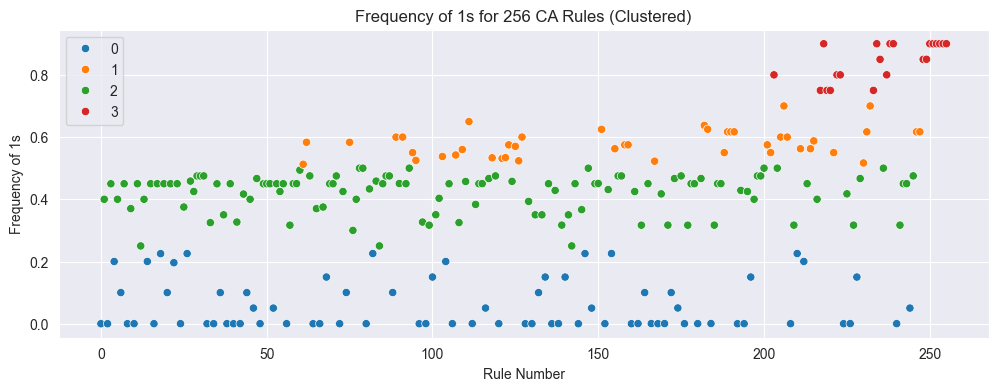

In [4]:

"""
Compute overall frequency of 1s in the entire CA grid and run simulation for all 256 rules
"""
def get_ones_frequency(grid):
    return np.sum(grid) / grid.size  # proportion of 1s in the grid

all_frequencies = [] # initialize list to store frequencies of 1s in the CA grid

for rule_num in range(256):   # Loop through all elementary rules
    ca_grid = run_ca(rule_num)   # Generate CA grid for each rule
    freq = get_ones_frequency(ca_grid)   # Compute frequency of 1s
    all_frequencies.append(freq)

all_frequencies = np.array(all_frequencies).reshape(-1, 1)  # normalize for clustering

#print(all_frequencies)

kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(all_frequencies)  # Cluster based on 1s frequency

# Visualize results 
plt.figure(figsize=(12, 4))
sns.scatterplot(x=np.arange(256), y=all_frequencies.flatten(), hue=labels, palette='tab10')
plt.title("Frequency of 1s for 256 CA Rules (Clustered)")
plt.xlabel("Rule Number")
plt.ylabel("Frequency of 1s")
plt.grid(True)
plt.show()



### Step 3: 
Visualizing the spatial-temporal evolution of different rules.

Rule 0 — Frequency of 1s: 0.08


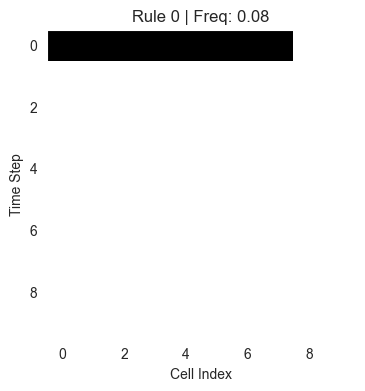

Rule 90 — Frequency of 1s: 0.48


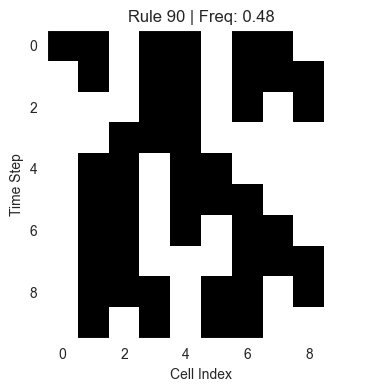

Rule 30 — Frequency of 1s: 0.43


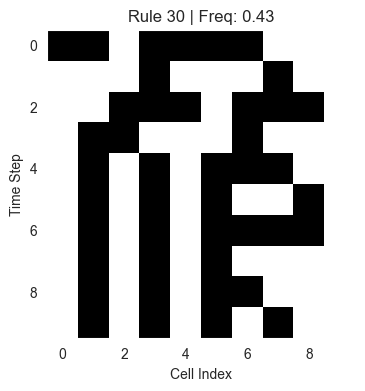

In [5]:
# Visualize Specific Rules and Their Frequencies 
def plot_grid(grid, rule_num, freq):
    plt.figure(figsize=(5, 4))
    plt.imshow(grid, cmap='Greys', interpolation='none')
    plt.title(f"Rule {rule_num} | Freq: {freq:.2f}")
    plt.xlabel("Cell Index")
    plt.ylabel("Time Step")
    plt.grid(False)
    plt.show()

# Key example rules to show contrast
example_rules = [0, 90, 30]

for rule in example_rules:
    grid = run_ca(rule, grid_size=10, time_steps=10, init_mode='random')
    freq = get_ones_frequency(grid)
    print(f"Rule {rule} — Frequency of 1s: {freq:.2f}")
    plot_grid(grid, rule, freq)
    

### Step 4 : 
Implementing a rule inference algorithm that reconstructs the original CA rule from the generated grid, validating its accuracy and robustness across multiple rule types.

In [6]:

"""
    Infer the rule number used to generate a CA grid.
    Assumes elementary CA (1D, 3-cell neighborhood).
    """
def infer_rule_from_grid(grid):
    rule_dict = {}  # Initialize dictionary to store inferred transitions
    rows, cols = grid.shape

    for t in range(1, rows):    # Iterate over time steps
        for i in range(1, cols - 1):  # Skip boundary cells
            neighborhood = ''.join(str(bit) for bit in grid[t - 1, i - 1:i + 2])
            output = grid[t, i]   # Observed next state

            # Check for consistency
            if neighborhood in rule_dict:
                if rule_dict[neighborhood] != output:
                    raise ValueError(f"Inconsistent output for neighborhood {neighborhood}")
            else:
                rule_dict[neighborhood] = output   # Record transition

    # Ensure all possible neighborhoods are accounted for
    required_keys = ['111', '110', '101', '100', '011', '010', '001', '000']
    if not all(k in rule_dict for k in required_keys):
        missing = [k for k in required_keys if k not in rule_dict]
        raise ValueError(f"Missing patterns in data: {missing}")

    # Convert inferred rule back to integer
    binary_string = ''.join(str(rule_dict[k]) for k in required_keys)
    rule_number = int(binary_string, 2)
    return rule_number


# Test Reverse Engineering
original_rule = 50
grid = run_ca(original_rule)  # run ca for a specific rule number
# infer the rule from the grid generated from rule 30 'Run CA'
inferred_rule = infer_rule_from_grid(grid)

print("\n--- Single Rule Inference Test ---")
print(f"Original Rule: {original_rule}")
print(f"Inferred Rule: {inferred_rule}")
assert inferred_rule == original_rule, "Rule inference failed!"  # check if the original rule equals inferred rule.



--- Single Rule Inference Test ---
Original Rule: 50
Inferred Rule: 50


In [7]:

# step 6:Test Reverse Engineering Robustness on Multiple Rules
"""
    Run reverse inference for a set of rule numbers and print result.
    """
def test_reverse_engineering_robustness(rules_to_test, grid_size=20, time_steps=10000):
    print("\n--- Reverse Engineering Robustness Test ---")
    for rule in rules_to_test:
        grid = run_ca(rule, grid_size=grid_size, time_steps=time_steps, init_mode='single')
        try:
            inferred = infer_rule_from_grid(grid)
            result = "PASS" if rule == inferred else "FAIL"
            print(f"Rule {rule:3d} → Inferred: {inferred:3d} — {result}")
        except Exception as e:
            print(f"Rule {rule:3d} → Error: {e}")

# Test with a diverse set of CA rules
test_rules = [0, 15, 18, 30, 45, 60, 90, 105, 110, 126, 150, 184]
test_reverse_engineering_robustness(test_rules)



--- Reverse Engineering Robustness Test ---
Rule   0 → Error: Missing patterns in data: ['111', '110', '101', '011']
Rule  15 → Inferred:  15 — PASS
Rule  18 → Error: Missing patterns in data: ['111', '110', '011']
Rule  30 → Inferred:  30 — PASS
Rule  45 → Inferred:  45 — PASS
Rule  60 → Inferred:  60 — PASS
Rule  90 → Error: Missing patterns in data: ['111', '110', '011']
Rule 105 → Inferred: 105 — PASS
Rule 110 → Inferred: 110 — PASS
Rule 126 → Inferred: 126 — PASS
Rule 150 → Inferred: 150 — PASS
Rule 184 → Error: Missing patterns in data: ['111', '110', '101', '011']
